In [5]:
from google.colab import drive
 

In [4]:
drive.mount('https://drive.google.com/drive/folders/16hNWcc5IMQUdpdLkU1N62JZRqBlAkmDO?usp=sharing/')

ValueError: ignored

In [6]:
drive.mount('/content/drive/')


Mounted at /content/drive/


In [7]:
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2022-05-22 02:33:43--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  29.7MB/s    in 1.5s    

2022-05-22 02:33:45 (29.7 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [8]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

In [9]:
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, num_kernels, kernel_size=3, bn=True, max_pool=True, maxpool_kernel_size=2):
#         super().__init__()
#         padding = (kernel_size - 1) // 2
#         n = len(num_kernels) - 1
#         self.convs = nn.ModuleList([nn.Conv2d(
#             num_kernels[i], num_kernels[i+1], kernel_size, padding=padding) for i in range(n)])
#         self.bn = nn.ModuleList([nn.BatchNorm2d(num_kernels[i+1])
#                                  for i in range(n)]) if bn else None
#         self.max_pool = nn.MaxPool2d(maxpool_kernel_size) if max_pool else None

#     def forward(self, x):
#         n = len(self.convs)
#         for i in range(n):
#             x = self.convs[i](x)
#             if self.bn is not None:
#                 x = self.bn[i](x)
#             x = F.relu(x) 
#             if self.max_pool is not None and i < n-1:  # check if i < n
#                 x = self.max_pool(x)
#         return x


# class TwoStreamNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         num_kernels = [3, 32, 64, 128, 256, 256]
#         self.face_encoding_module = Encoder(num_kernels)
#         self.context_encoding_module = Encoder(num_kernels)
#         self.attention_inference_module = Encoder(
#             [1, 26, 512], max_pool=False)

#     def forward(self, face, context):
#         face = self.face_encoding_module(face)

#         context = self.context_encoding_module(context)
#         attention = self.attention_inference_module(context)
#         N, C, H, W = attention.shape
#         attention = F.softmax(attention.view(
#             N, -1), dim=-1).view(N, C, H, W)
#         context = context * attention

#         return face, context


# class FusionNetwork(nn.Module):
#     def __init__(self, use_face=True, use_context=True, concat=False, num_class=7):
#         super().__init__()
#         # add batch norm to ensure the mean and std of 
#         # face and context features are not too different
#         self.face_bn = nn.BatchNorm1d(256)
#         self.context_bn = nn.BatchNorm1d(256)

#         self.use_face, self.use_context = use_face, use_context
#         self.concat = concat

#         self.face_1 = nn.Linear(256, 128)
#         self.face_2 = nn.Linear(128, 1)

#         self.context_1 = nn.Linear(256, 128)
#         self.context_2 = nn.Linear(128, 1)

#         self.fc1 = nn.Linear(512, 128)
#         self.fc2 = nn.Linear(128, num_class)

#         self.dropout = nn.Dropout()

#     def forward(self, face, context):
#         face = F.avg_pool2d(face, face.shape[2]).view(face.shape[0], -1)
#         context = F.avg_pool2d(context, context.shape[2]).view(context.shape[0], -1)

#         # add batch norm for face and context branch
#         face, context = self.face_bn(face), self.context_bn(context)

#         if not self.concat:
#             lambda_f = F.relu(self.face_1(face))
#             lambda_c = F.relu(self.context_1(context))

#             lambda_f = self.face_2(lambda_f)
#             lambda_c = self.context_2(lambda_c)

#             weights = torch.cat([lambda_f, lambda_c], dim=-1)
#             weights = F.softmax(weights, dim=-1)
#             face = face * weights[:, 0].unsqueeze(dim=-1)
#             context = context * weights[:, 1].unsqueeze(dim=-1)

#         if not self.use_face:
#             face = torch.zeros_like(face)

#         if not self.use_context:
#             context = torch.zeros_like(context)

#         features = torch.cat([face, context], dim=-1)
#         features = F.relu(self.fc1(features))
#         features = self.dropout(features)

#         return self.fc2(features)


In [12]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()
    # self.attention_inference_module = Encoder(
    #         [1, 26, 512], max_pool=False)

    
  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    # attention = self.attention_inference_module(context_features)
    # N, C, H, W = attention.shape
    # attention = F.softmax(attention.view(
    #         N, -1), dim=-1).view(N, C, H, W)
    # context_features = context_features * attention
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)    
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


In [13]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [14]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


In [19]:
# os.listdir('./drive/MyDrive/emotic/dataset/')

In [20]:
# Change data_src variable as per your drive
data_src = './drive/MyDrive/emotic/dataset/'
print(os.listdir('./drive/MyDrive/emotic/dataset'))

# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'pre','train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'pre','train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))

# Load validation preprocessed data 
val_context = np.load(os.path.join(data_src,'pre','val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'pre','val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'pre','test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'pre','test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

['pre']
train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [21]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(), 
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


In [22]:
 model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

completed cell


In [23]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


In [24]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)
    
    emotic_model.train()
    model_context.train()
    model_body.train()
    
    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0: 
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)

    
    running_loss = 0.0 
    emotic_model.eval()
    model_context.eval()
    model_body.eval()
    
    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        
        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        running_loss += loss.item()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
      
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')
  
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


epoch = 0 training loss = 66228.8399
epoch = 0 validation loss = 6373.5083
saving model at epoch e = 0
epoch = 1 training loss = 48204.3673
epoch = 1 validation loss = 5859.2502
saving model at epoch e = 1
epoch = 2 training loss = 45935.1365
epoch = 2 validation loss = 5875.5767
epoch = 3 training loss = 44507.4492
epoch = 3 validation loss = 5739.7135
saving model at epoch e = 3
epoch = 4 training loss = 43673.4780
epoch = 4 validation loss = 5584.7035
saving model at epoch e = 4
epoch = 5 training loss = 42968.9522
epoch = 5 validation loss = 5595.6040
epoch = 6 training loss = 42684.5849
epoch = 6 validation loss = 5573.9979
saving model at epoch e = 6
epoch = 7 training loss = 41778.4109
epoch = 7 validation loss = 5531.4430
saving model at epoch e = 7
epoch = 8 training loss = 41531.4383
epoch = 8 validation loss = 5514.2976
saving model at epoch e = 8
epoch = 9 training loss = 41474.1913
epoch = 9 validation loss = 5583.9184
epoch = 10 training loss = 41201.3799
epoch = 10 valid

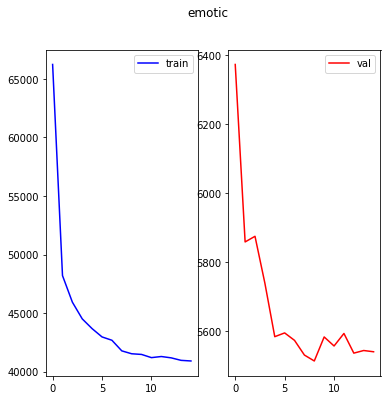

In [25]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)


In [26]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [27]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean 

print ('completed cell')

completed cell


In [28]:
model_context = torch.load('./models/model_context1.pth')
model_body = torch.load('./models/model_body1.pth')
emotic_model = torch.load('./models/model_emotic1.pth')

print ('completed cell')

completed cell


In [29]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())


print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.39589655 0.17729595 0.22383824 0.9504204  0.16989021 0.7885437
 0.24017753 0.36255515 0.17960462 0.21582718 0.05714972 0.9805134
 0.26840413 0.78994596 0.1436883  0.0752566  0.8040565  0.17843242
 0.2818185  0.48860344 0.20861332 0.07643481 0.1940393  0.14723356
 0.3735377  0.11372239] (26,) 0.34175
vad [0.7099849  0.8492047  0.88067496] (3,) 0.8132882
0.34175 0.8132882
starting testing
completed testing
ap [0.2903963  0.08126023 0.14789335 0.56403565 0.07443753 0.75944984
 0.12032154 0.23481901 0.1595329  0.16986    0.0203989  0.86038023
 0.15170297 0.6921719  0.09370683 0.05271833 0.6606729  0.06944937
 0.21770258 0.41781622 0.17151518 0.06234511 0.16954488 0.08473141
 0.12454293 0.08017804] (26,) 0.25121477
vad [0.9047907 1.0245103 0.9487974] (3,) 0.95936614
0.25121477 0.95936614
validation Mean average precision=0.3417 Mean VAD MAE=0.8133
testing Mean average precision=0.2512 Mean VAD MAE=0.9594


In [30]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference 
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 7203) (26, 7203)
[0.11812452 0.3114896  0.16338527 0.18283746 0.26239574 0.12820062
 0.21291381 0.10386502 0.07434382 0.07472923 0.1300908  0.4826839
 0.08529293 0.14433067 0.10626721 0.12143396 0.22884493 0.27988067
 0.10499336 0.10877734 0.1690233  0.146115   0.25936565 0.0980337
 0.10433139 0.08303645] (26,)
completed cell


In [31]:
def calculateAccuracy(y_true,y_pred):
  accuracy = (100-np.mean(np.abs(y_true-y_pred)))*100
  return accuracy

In [32]:
!apt install octave


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-noto-mono ghostscript gnuplot-data
  gnuplot-qt gsfonts imagemagick-6-common info install-info libamd2
  libauthen-sasl-perl libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcupsfilters1 libcupsimage2 libcxsparse3 libdata-dump-perl libemf1
  libencode-locale-perl libfftw3-single3 libfile-listing-perl libfltk-gl1.3
  libfltk1.3 libfont-afm-perl libgail-common libgail18 libglpk40
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-mess

In [33]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)'; 
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);
    
  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Writing eval.m


In [34]:
!octave -W eval.m

Streaming output truncated to the last 5000 lines.
   5.7220e-02   7.5027e-02   4.8702e-02  -2.7483e-02   7.6000e-02   6.9682e-02
   2.2474e-02   2.6552e-02   4.0210e-02   4.9162e-02   1.8651e-02   1.0671e-01
   2.6119e-02   3.6199e-02   4.0762e-02   4.3168e-03   4.8639e-02   1.0984e-01
   4.2518e-02   3.6936e-02   9.1446e-02   4.2587e-03   5.6972e-02   1.1812e-01
   5.1752e-01   6.5315e-01   5.3729e-01   6.2640e-01   5.5402e-01   3.8652e-01
   9.1975e-02   4.9691e-02   2.9723e-02   7.7361e-02   5.6782e-02   7.8827e-02
   2.0260e-01   1.0305e-01   2.8482e-01   4.0959e-01   8.3410e-02   8.3900e-02
   1.0768e-02   3.4823e-02   2.1708e-02   4.1320e-02   6.6221e-02   7.3720e-02
   3.6907e-02   6.0023e-03   5.5661e-02  -5.5059e-03   2.3963e-02   8.8757e-02
   3.0401e-01   1.6311e-01   2.2760e-01   6.9890e-02   2.1791e-01   2.7499e-01
   2.2670e-02  -3.1218e-04   6.0856e-02   1.4612e-02  -8.8897e-05   9.9914e-02
   8.7916e-02   8.0846e-02   5.9495e-02  -3.3461e-02   1.0263e-01   7.4733e-02
 